In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T151104Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8edb8aa20eef0796aa98ee8bd6a4adc8158c90b3ba70ec695ed916ecece4a12e8420d681399d395fecf09e7546d79463cd947e93adc19eccba72fb829951515452c7e33bc09d47d4607cc7901ad0f975969883b6db3b73b2a94dc73f2e608ebe1d4776e1e28bf5fbff4f838968cac14c68a4c0756c28f5ffc3ecbeb874536979fbda8870c05ecf87e081c6dfb98492c8237c8c9c419a9774bbbe28292f4f11266114b781bd620857bef95b216c04f361f9b6b8fb8721e25caaa5990dab392a58a9138bd8a98ccddfabf26a4232dfc3931ee6206fca1f6d8020327b8c70ba38d6af4ab52ab48ea94b7742f298216633b2cdc368f0d1f70515f36aa5baf0d18f6b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [4]:
#Load Dataset

train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# Explore the data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Preprocessing
### 1. Separate Features and Labels
Split the training data into features (x) and labels (y).

In [5]:
X_train = train.drop('label', axis=1).values
y_train = train['label'].values

### 3. Reshaping the data
For training neural networks like CNNs, reshape the 1D arrays into 2D images (28x28 pixels) with a single colour channel.

In [6]:
X_train = X_train.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

### 2. Normalization
Normalize pixel values to the range [0,1] by dividing by 255. Neural netwoks perform better with normalized data.

In [7]:
X_train = X_train.astype('float32') / 255.0
test = test.astype('float32') / 255.0

### Visualize a few examples from the dataset

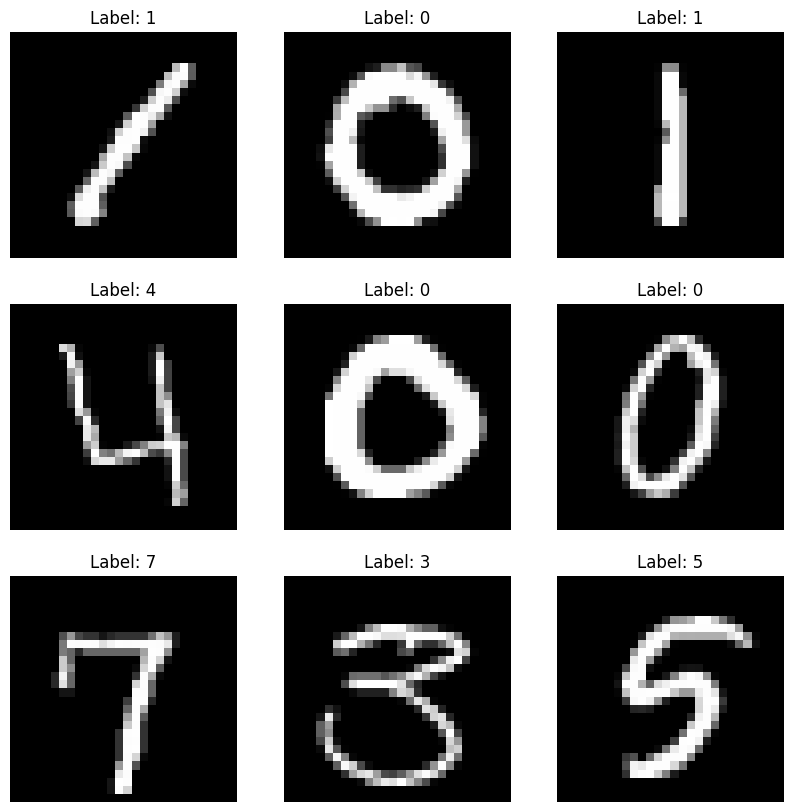

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

### 4. One-Hot Encoding (Optional)
If you are using deep learning model with a categorical output layer, convert labels into one-hot encoded values.

In [9]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

### Building the model

In [10]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Create a CNN model
model = Sequential()

# Add layers to the model
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), verbose=2)

# Evaluate the model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
296/296 - 35s - 117ms/step - accuracy: 0.8551 - loss: 0.4595 - val_accuracy: 0.9683 - val_loss: 0.1097
Epoch 2/10
296/296 - 32s - 108ms/step - accuracy: 0.9558 - loss: 0.1433 - val_accuracy: 0.9764 - val_loss: 0.0706
Epoch 3/10
296/296 - 40s - 134ms/step - accuracy: 0.9680 - loss: 0.1056 - val_accuracy: 0.9814 - val_loss: 0.0550
Epoch 4/10
296/296 - 41s - 138ms/step - accuracy: 0.9729 - loss: 0.0879 - val_accuracy: 0.9840 - val_loss: 0.0496
Epoch 5/10
296/296 - 41s - 140ms/step - accuracy: 0.9767 - loss: 0.0752 - val_accuracy: 0.9864 - val_loss: 0.0439
Epoch 6/10
296/296 - 40s - 135ms/step - accuracy: 0.9807 - loss: 0.0672 - val_accuracy: 0.9869 - val_loss: 0.0419
Epoch 7/10
296/296 - 30s - 102ms/step - accuracy: 0.9817 - loss: 0.0604 - val_accuracy: 0.9886 - val_loss: 0.0381
Epoch 8/10
296/296 - 32s - 109ms/step - accuracy: 0.9826 - loss: 0.0549 - val_accuracy: 0.9886 - val_loss: 0.0349
Epoch 9/10
296/296 - 41s - 140ms/step - accuracy: 0.9825 - loss: 0.0572 - val_accuracy: 

Using CNNs

### Model Evaluation and Predictions

Once the model is trained, you can evaluate it on the training/validation data and make predictions for the test set.

In [11]:
# Predict labels for test data
predictions = model.predict(test)

# Convert predictions to label indices
predictions = np.argmax(predictions, axis=1)

# Prepare the submission file
submission = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
Submission file created successfully!
